In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.special import binom

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init

from collections import Counter
import operator
import copy
from itertools import product,combinations
from time import time
#from IPython.core.display import display

%matplotlib inline

## code extracted from https://www.kaggle.com/code/graymant/breast-cancer-diagnosis-with-pytorch
## SV code extracted from https://

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [4]:
import os
import sys
from os.path import join as osj
from bisect import bisect
from collections import defaultdict
import pickle
import json
import wfdb

In [5]:
def read_dict_beats():
    with open(DICT_BEATS, "rb") as f:
        return pickle.load(f)

def read_data_beats():
    with open(DATA_BEATS, "rb") as f:
        return pickle.load(f)

def ensure_normalized_and_detrended(beats):
    for key in beats.keys():
        b = beats[key]["beats"]
        if not np.allclose(np.linalg.norm(b, axis=1, ord=2), 1):
            raise AssertionError(f"Beats of patient {key} is not normalized.")

        p = np.polyfit(np.arange(b.shape[1]), b.T, deg=1)
        if not np.allclose(p, 0):
            raise AssertionError(f"Beats of patient {key} is not detrended.")

DATA_ROOT =  "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/data"
DATA_BEATS = osj(DATA_ROOT, "30min_beats.pkl")

RECORDS = osj(DATA_ROOT, "RECORDS")
print(RECORDS)
patient_ids = pd.read_csv(RECORDS,  header=None).to_numpy().reshape(-1)
print(patient_ids)
data_beats = read_data_beats()
ensure_normalized_and_detrended(data_beats)

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/data/RECORDS
[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]


In [6]:
def get_paced_patients(patient_ids):
    paced = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(DATA_ROOT, str(id_)), extension='atr')
        labels = np.unique(annotation.symbol)
        if ("/" in labels):
            paced.append(id_)
    return np.array(paced)
paced_patients = np.array([102, 104, 107, 217])
excluded_patients = np.array([]) #np.array([105, 114, 201, 202,207, 209, 213, 222, 223, 234]) # according to paper
print(np.concatenate((paced_patients,excluded_patients)))

[102. 104. 107. 217.]


In [7]:
import collections
patients_out = np.concatenate((paced_patients,excluded_patients))
print(patients_out)
patients_left = list(copy.deepcopy(patient_ids))

for idx,i in enumerate(patient_ids):
    if i in patients_out:
        patients_left.remove(i)

print(patients_left)

#print(dict_beats[101]['beats'])
#print(dict_beats[101]['class'])
labels = ['N','V','S','Q','F']
dictionary = {}
for i in labels:
    dictionary[i] = 0

list1 = []
array = np.zeros((len(patients_left),2))
labels2 = []
for idx,i in enumerate(patients_left):
    for ii in data_beats[i]['label']:
        if ii not in labels2:
            labels2.append(ii)
    #print(len(data_beats[i]['class']))
    list1.append(data_beats[i]['class'])
    counter = collections.Counter(data_beats[i]['class'])
    for j in counter.keys():
        dictionary[j] += counter[j]
        if j == 'N':
            array[idx,0] += counter[j]
        else:
            array[idx,1] += counter[j]
print(labels2)

[102. 104. 107. 217.]
[100, 101, 103, 105, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]
['N', 'A', 'V', 'Q', 'F', 'j', 'L', 'a', 'J', 'R', 'E', 'S', 'e']


In [8]:
def train_test_split(data_beats,seconds=5,factor=0.8):
    data_beats_train = {}
    data_beats_val = {}
    data_beats_test = {}
    for i in data_beats.keys():
        data_beats_train[i] = {'class':None, 'beats':None}
        data_beats_val[i] = {'class':None, 'beats':None}
        data_beats_test[i] ={'class':None, 'beats':None}

    for patient in data_beats.keys():
        length = int(np.ceil(len(data_beats[patient]['beats'])*(seconds/30))) # only take first 5 seconds

        random_test = np.arange(length)
        random_train = np.random.choice(random_test,size=int(np.ceil(0.8*length)),replace=False)
        for ii in random_train:
            index = np.where(random_test == ii)[0]
            random_test = np.delete(random_test,index)

        random_val = np.arange(int(np.ceil(0.8*length)))
        random_train = np.random.choice(random_val,size=int(np.ceil(0.8*0.8*length)),replace=False)
        for ii in random_train:
            index = np.where(random_val == ii)[0]
            random_val = np.delete(random_val,index)

        data_beats_train[patient]['class'] = data_beats[patient]['class'][np.sort(random_train)]
        data_beats_test[patient]['class'] = data_beats[patient]['class'][random_test]
        data_beats_val[patient]['class'] = data_beats[patient]['class'][random_val]
        data_beats_train[patient]['beats'] = data_beats[patient]['beats'][np.sort(random_train)]
        data_beats_test[patient]['beats'] = data_beats[patient]['beats'][random_test]
        data_beats_val[patient]['beats'] = data_beats[patient]['beats'][random_val]


    return data_beats_train, data_beats_val, data_beats_test
#print(data_beats_train)
seconds = 5
data_beats_train, data_beats_val, data_beats_test  = train_test_split(data_beats,seconds=5)

In [9]:
# TODO: concatenate the two datasets here
# Load supraventricular dataset: 
DATA_ROOT =  "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/data"
DATA_BEATS = osj(DATA_ROOT, "30min_beats_supraventricular.pkl")

RECORDS = osj(DATA_ROOT, "RECORDS_S")
print(RECORDS)
patient_ids_sup = pd.read_csv(RECORDS,  header=None).to_numpy().reshape(-1)
print(patient_ids)
print(patient_ids_sup)
data_beats_sup = read_data_beats()
ensure_normalized_and_detrended(data_beats_sup)
seconds = 5
data_beats_train_sup, data_beats_val_sup, data_beats_test_sup  = train_test_split(data_beats_sup,seconds=5)

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/data/RECORDS_S
[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]
[800 801 802 803 804 805 806 807 808 809 810 811 812 820 821 822 823 824
 825 826 827 828 829 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870
 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888
 889 890 891 892 893 894]


In [10]:
# concatenate the datasets
data_beats_tr = {}
data_beats_tr.update(data_beats_train)
data_beats_tr.update(data_beats_train_sup)

data_beats_v = {}
data_beats_v.update(data_beats_val)
data_beats_v.update(data_beats_val_sup)

data_beats_t = {}
data_beats_t.update(data_beats_test)
data_beats_t.update(data_beats_test_sup)
print(patients_left)
print(patient_ids)
print(list(data_beats_tr.keys()))

[100, 101, 103, 105, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]
[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]
[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 88

In [13]:
patients_left = [x for x in list(data_beats_tr.keys()) if x not in paced_patients]
patients_healthy = []
patients_unhealthy = []
patients_really_unhealthy = []
for i in range(len(patients_left)):
        print('patient ',i)
        print('N: ',np.count_nonzero(data_beats_tr[patients_left[i]]['class']=='N'))
        print('V: ',np.count_nonzero(data_beats_tr[patients_left[i]]['class']=='V'))
        V = np.count_nonzero(data_beats_tr[patients_left[i]]['class']=='V')
        S = np.count_nonzero(data_beats_tr[patients_left[i]]['class']=='S')
        F = np.count_nonzero(data_beats_tr[patients_left[i]]['class']=='F')
        print('S: ',np.count_nonzero(data_beats_tr[patients_left[i]]['class']=='S'))
        print('F: ',np.count_nonzero(data_beats_tr[patients_left[i]]['class']=='F'))
        if V + S + F >= 10:
            patients_really_unhealthy.append(patients_left[i])
        else:
            patients_unhealthy.append(patients_left[i])
print('moderately unhealthy patients: ',patients_unhealthy)
print('very unhealthy patients: ',patients_really_unhealthy)

patient  0
N:  242
V:  0
S:  1
F:  0
patient  1
N:  200
V:  0
S:  0
F:  0
patient  2
N:  223
V:  0
S:  0
F:  0
patient  3
N:  265
V:  10
S:  0
F:  0
patient  4
N:  171
V:  46
S:  0
F:  0
patient  5
N:  186
V:  3
S:  0
F:  0
patient  6
N:  267
V:  2
S:  0
F:  2
patient  7
N:  227
V:  0
S:  0
F:  0
patient  8
N:  271
V:  0
S:  0
F:  0
patient  9
N:  191
V:  0
S:  1
F:  0
patient  10
N:  193
V:  7
S:  1
F:  0
patient  11
N:  209
V:  0
S:  0
F:  0
patient  12
N:  252
V:  6
S:  0
F:  0
patient  13
N:  164
V:  0
S:  0
F:  0
patient  14
N:  235
V:  3
S:  6
F:  0
patient  15
N:  159
V:  53
S:  0
F:  0
patient  16
N:  200
V:  0
S:  0
F:  0
patient  17
N:  265
V:  0
S:  0
F:  0
patient  18
N:  162
V:  0
S:  0
F:  0
patient  19
N:  173
V:  0
S:  0
F:  0
patient  20
N:  188
V:  89
S:  1
F:  0
patient  21
N:  209
V:  0
S:  1
F:  0
patient  22
N:  226
V:  2
S:  0
F:  0
patient  23
N:  277
V:  41
S:  1
F:  0
patient  24
N:  284
V:  0
S:  0
F:  0
patient  25
N:  118
V:  81
S:  0
F:  0
patient  26
N:  

['N', 'A', 'V', 'Q', 'F', 'j', 'L', 'a', 'J', 'R', 'E', 'S', 'e']


Text(0, 0.5, '% Subventricular divided by ventricular')

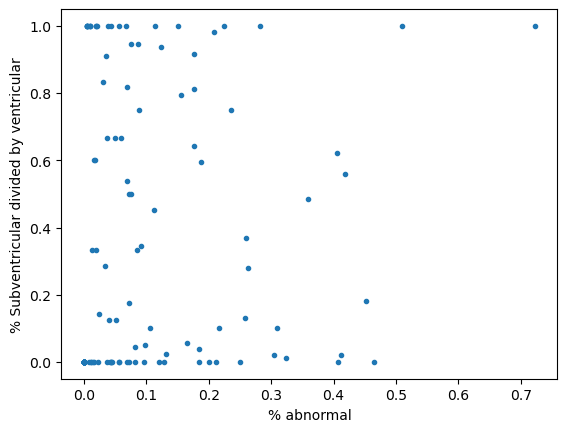

In [19]:
# TODO: plot x-axis (S/V ratio) plot y-axis (% arrhythmia)
print(labels2)
abnratios = []
svratios = []
for idx,i in enumerate(patients_left):
    normal_beats = 0
    abnormal_beats = 0
    S = 0
    V = 0
    for ii in data_beats_tr[i]['class']:
        if ii == 'N':
            normal_beats += 1
        else:
            if ii == 'V' or 'F' or 'S':
      # take into account that there are classes that we exclude (later)
                abnormal_beats += 1
                if ii == 'V':
                    V += 1
                if ii == 'S':
                    S += 1

    ratio = abnormal_beats/(normal_beats+abnormal_beats)
    svratio = S/(V+S+0.001)
    abnratios.append(ratio)
    svratios.append(svratio)

plt.plot(abnratios,svratios,'.')
plt.xlabel('% abnormal')
plt.ylabel('% Subventricular divided by ventricular')

In [125]:
print(abnratios)

[0.00411523 0.         0.         0.03636364 0.21198157 0.01587302
 0.01476015 0.         0.         0.00520833 0.039801   0.
 0.02325581 0.         0.03688525 0.25       0.         0.
 0.         0.         0.32374101 0.0047619  0.00877193 0.13166144
 0.         0.40703518 0.46518987 0.01869159 0.08127208 0.
 0.21613833 0.11983471 0.06944444 0.04347826 0.00456621 0.18461538
 0.         0.07194245 0.20091324 0.         0.01190476 0.72251309
 0.30395137 0.         0.00995025 0.45149254 0.01117318 0.07239819
 0.04290429 0.05691057 0.01547988 0.01923077 0.         0.
 0.04433498 0.01960784 0.0964467  0.07569721 0.1761194  0.51004016
 0.1503268  0.12403101 0.11371237 0.06666667 0.00502513 0.22439024
 0.04285714 0.         0.01010101 0.01824818 0.         0.
 0.03571429 0.         0.06878307 0.         0.02164502 0.
 0.18505338 0.0245614  0.07531381 0.35958904 0.23616236 0.04918033
 0.11231884 0.         0.10582011 0.31007752 0.20833333 0.01282051
 0.17664671 0.09852217 0.08579882 0.0912280

18.0
1.7582938388625593
2.3894247515911733
3.0903717578961647


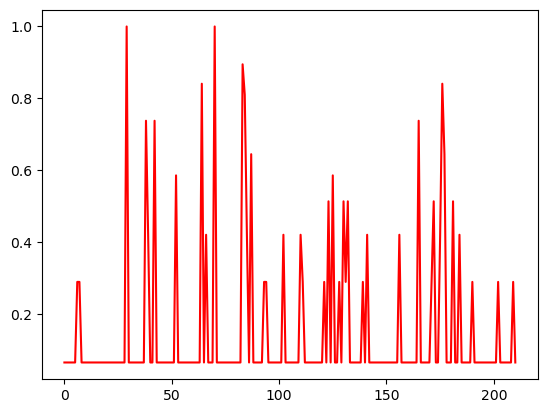

In [119]:
print(np.max(phi))
print(np.mean(phi[phi>0]))
print(np.std(phi[phi>0]))
logs = np.random.exponential(scale=2,size=100)
#plt.plot(np.ravel(phi))
#plt.plot(np.ravel(phi))
log_data = np.sqrt(np.ravel(phi[phi>0]))
log_data = np.ravel(phi[phi>0])
log_data = 0.2 + np.log(phi[phi>0])
#print(log_data[log_data>0])
plt.plot((log_data)/max(log_data),'r')
print(max(log_data))

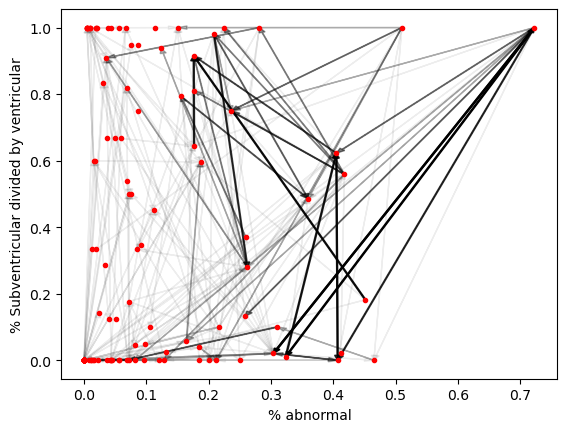

In [135]:
phi = np.loadtxt('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits/test2/phi24.txt')
p1,p2 = np.where(phi>=1)

abnratios = np.array(abnratios)
svratios = np.array(svratios)
x_1 = abnratios[p2]
x_2 = abnratios[p1]
y_1 = svratios[p2]
y_2 = svratios[p1]

#plt.title('10 most common')

plt.xlabel('% abnormal')
plt.ylabel('% Subventricular divided by ventricular')
for j in range(len(p1)):
    if phi[p1[j],p2[j]] >0: 
        plt.arrow(x_1[j],y_1[j],x_2[j]-x_1[j],y_2[j]-y_1[j],length_includes_head=True,
              width=(0.2+np.log(phi[p1[j],p2[j]]))/np.max(log_data)*0.002, facecolor='k',
              head_width=0.01,alpha=(0.2+np.log(phi[p1[j],p2[j]]))/np.max(log_data)) #alpha=np.sqrt(phi[p1[j],p2[j]])/np.max(log_data))
    

plt.plot(abnratios,svratios,'r.')
#plt.plot(np.repeat(0.2,100),np.linspace(0,1,100),'b--')
#plt.plot(np.linspace(0,0.7,100),np.repeat(0.333,100),'b--')
#plt.plot(np.linspace(0,0.7,100),np.repeat(0.666,100),'b--')

In [127]:
# unhealthy, moderately healthy, very unhealthy 
p1,p2 = np.where(phi>=1)
abnratios = np.array(abnratios)
svratios = np.array(svratios)
x_1 = abnratios[p1]
x_2 = abnratios[p2]
y_1 = svratios[p1]
y_2 = svratios[p2]

HEHE = 0 
HEMH = 0 
HEU = 0 
MHMH = 0 
MHHE = 0 
MHU = 0 
UU = 0 
UMH = 0 
UHE = 0 
th = 0.2
for j in range(len(p1)):
    if x_2[j] >= th and x_1[j] >= th: 
        UU += phi[p1[j],p2[j]]
    if 0<x_2[j]< th and 0<x_1[j]< th: 
        MHMH += phi[p1[j],p2[j]]
    if x_2[j] == 0 and x_1[j] == 0: 
        HEHE += phi[p1[j],p2[j]]
        
    if x_2[j] >= th and x_1[j] == 0: 
        UHE += phi[p1[j],p2[j]]
    if x_2[j] >= th and 0<x_1[j]<th: 
        UMH += phi[p1[j],p2[j]]
    if x_2[j] == 0 and x_1[j] >= th: 
        HEU += phi[p1[j],p2[j]]
    if x_2[j] ==0 and 0<x_1[j]<th: 
        HEMH += phi[p1[j],p2[j]]
    if 0<x_2[j]<th and x_1[j] >= th: 
        MHU += phi[p1[j],p2[j]]
    if 0<x_2[j]<th and x_1[j] == 0: 
        MHHE += phi[p1[j],p2[j]]
print('UU',UU)
print('MHMH',MHMH)
print('HEHE',HEHE)
print('UHE',UHE)
print('UMH',UMH)
print('HEU',HEU)
print('MHU',MHU)
print('MHHE',MHHE)
print('HEMH',HEMH)
    

UU 159.0
MHMH 58.0
HEHE 2.0
UHE 7.0
UMH 74.0
HEU 7.0
MHU 32.0
MHHE 10.0
HEMH 22.0


In [128]:
p1,p2 = np.where(phi>=1)
abnratios = np.array(abnratios)
svratios = np.array(svratios)
x_1 = svratios[p1]
x_2 = svratios[p2]

SS = 0 
VV = 0 
MM = 0 
SV = 0
SM = 0
VS = 0 
VM = 0 
MS = 0 
MV = 0 

th1 = 0.333
th2 = 0.666
for j in range(len(p1)):
    if x_2[j] >= th2 and x_1[j] >= th2: 
        SS += phi[p1[j],p2[j]]
    if th1<x_2[j]< th2 and th1<x_1[j]< th2: 
        MM += phi[p1[j],p2[j]]
    if x_2[j] < th1 and x_1[j] < th1: 
        VV += phi[p1[j],p2[j]]
        
    if x_2[j] >= th2 and x_1[j] < th1: 
        SV += phi[p1[j],p2[j]]
        
    if x_2[j] >= th2 and th1<x_1[j]<th2: 
        SM += phi[p1[j],p2[j]]
        
    if th1<x_2[j]<th2 and x_1[j] >= th2: 
        MS += phi[p1[j],p2[j]]
        
    if x_2[j] <th1 and th1<x_1[j]<th2: 
        VM += phi[p1[j],p2[j]]
        
    if x_2[j]<th1 and x_1[j] >= th2: 
        VS += phi[p1[j],p2[j]]
    if th1<x_2[j]<th2 and x_1[j] < th1: 
        MV += phi[p1[j],p2[j]]
print('VV',VV)
print('SS',SS)
print('MM',MM)
print('VS',VS)
print('SV',SV)
print('VM',VM)
print('MV',MV)
print('SM',SM)
print('MS',MS)

VV 84.0
SS 18.0
MM 2.0
VS 57.0
SV 78.0
VM 47.0
MV 18.0
SM 27.0
MS 40.0


In [121]:
# collab mostly between half of SV and either of the two
#phi = np.loadtxt('/content/drive/MyDrive/checkpoints_bandits/test2/phi24.txt')
p1,p2 = np.where(phi>=1)
abnratios = np.array(abnratios)
svratios = np.array(svratios)
x_1 = abnratios[p1]
x_2 = abnratios[p2]
y_1 = svratios[p1]
y_2 = svratios[p2]

false = 0
true = 0
for j in range(len(p1)):
    if y_2[j] >= y_1[j]:
        false += int(phi[p1[j],p2[j]])
    else:
        true  += int(phi[p1[j],p2[j]])
print(false)
print(true)

70
57


In [122]:
# collab with more or less seizures?
#phi = np.loadtxt('/content/drive/MyDrive/checkpoints_bandits/test2/phi24.txt')
p1,p2 = np.where(phi>=5)
abnratios = np.array(abnratios)
svratios = np.array(svratios)
x_1 = abnratios[p1]
x_2 = abnratios[p2]
y_1 = svratios[p1]
y_2 = svratios[p2]

false = 0
true = 0
for j in range(len(p1)):
    if x_1[j] >= x_2[j]:
        false += int(phi[p1[j],p2[j]])
    else:
        true  += int(phi[p1[j],p2[j]])
print(false)
print(true)
print(false/(false+true))

43
84
0.33858267716535434


In [ ]:
phi = np.loadtxt('/content/drive/MyDrive/checkpoints_bandits/test/phi24.txt')
p1,p2 = np.where(phi>=5)
abnratios = np.array(abnratios)
svratios = np.array(svratios)
x_1 = abnratios[p1]
x_2 = abnratios[p2]
y_1 = svratios[p1]
y_2 = svratios[p2]

plt.title('10 most common')

plt.xlabel('% abnormal')
plt.ylabel('% Subventricular divided by ventricular')
for j in range(len(p1)):
  if x_2[j] >= x_1[j]:
    plt.plot([x_1[j],x_2[j]],[y_1[j],y_2[j]],'b-',linewidth=int(phi[p1[j],p2[j]])/3)

plt.plot(abnratios,svratios,'k.')


In [ ]:
plt.title('10 most common')

plt.xlabel('% abnormal')
plt.ylabel('% Subventricular divided by ventricular')
for j in range(len(p1)):
  if x_1[j] > x_2[j]:
    plt.plot([x_1[j],x_2[j]],[y_1[j],y_2[j]],'r-',linewidth=int(phi[p1[j],p2[j]])/3)

plt.plot(abnratios,svratios,'k.')

[(-0.01, 0.15), (-0.01, 0.15)]

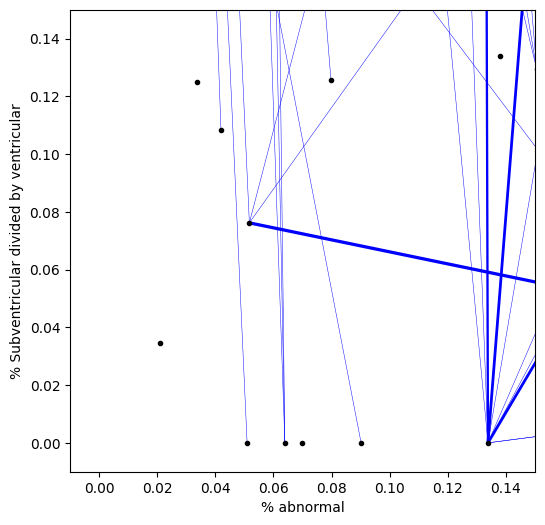

In [9]:
phi = np.loadtxt('/content/drive/MyDrive/checkpoints_bandits/test/phi24.txt')
p1,p2 = np.where(phi>=1)
abnratios = np.array(abnratios)
svratios = np.array(svratios)
x_1 = abnratios[p1]
x_2 = abnratios[p2]
y_1 = svratios[p1]
y_2 = svratios[p2]

#plt.title('10 most common')
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot()

plt.xlabel('% abnormal')
plt.ylabel('% Subventricular divided by ventricular')
for j in range(len(p1)):
 # if x_2[j] >= x_1[j]:
    plt.plot([x_1[j],x_2[j]],[y_1[j],y_2[j]],'b-',linewidth=int(phi[p1[j],p2[j]])/3)

plt.plot(abnratios,svratios,'k.')
ax.set(xlim=(-0.01, 0.15), ylim=(-0.01, 0.15))

In [ ]:
# TODO: plot x-axis (S/V ratio) plot y-axis (% arrhythmia)
print(labels2)
abnratios = []
svratios = []
for idx,i in enumerate(patients_left):
    normal_beats = 0
    abnormal_beats = 0
    S = 0
    V = 0
    for ii in data_beats[i]['class']:
      if ii == 'N':
        normal_beats += 1
      else:
        if ii == 'V' or 'F' or 'S':
      # take into account that there are classes that we exclude (later)
          abnormal_beats += 1
          if ii == 'V':
            V += 1
          if ii == 'S':
            S += 1

    ratio = V/(normal_beats+abnormal_beats)
    svratio = S/(normal_beats+abnormal_beats)
    abnratios.append(ratio)
    svratios.append(svratio)

plt.plot(abnratios,svratios,'.')
plt.xlabel('% abnormal')
plt.ylabel('% Subventricular divided by ventricular')

